In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import shap
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
import sklearn
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, brier_score_loss, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Read Files

In [2]:
csv_folder = 'C:/Users/Neil/OneDrive/Documents/Capstone Files/' ### make sure na lahat ng csv ay nasa isang folder tapos dapat yung features lang yung nandun
csv_files = sorted(glob.glob(os.path.join(csv_folder, "*.csv")))  # Get all CSV files

In [3]:
csv_files

['C:/Users/Neil/OneDrive/Documents/Capstone Files\\Car Features M1-24.csv',
 'C:/Users/Neil/OneDrive/Documents/Capstone Files\\Car Features M13-36.csv',
 'C:/Users/Neil/OneDrive/Documents/Capstone Files\\Car Features M25-48.csv',
 'C:/Users/Neil/OneDrive/Documents/Capstone Files\\Car Features M37-60.csv']

## Splitting

In [4]:
selected_features = [
    'EverAtLeast1DPD_3mos', 
    'EverAtLeast15DPD_3mos', 'EverAtLeast31DPD_3mos', 
    'EverAtLeast61DPD_3mos', 
    'EverAtLeast1DPD_6mos', 
    'EverAtLeast15DPD_6mos', 'EverAtLeast31DPD_6mos', 
    'EverAtLeast61DPD_6mos', 
    'EverAtLeast1DPD_9mos', 
    'EverAtLeast15DPD_9mos', 'EverAtLeast31DPD_9mos', 'EverAtLeast61DPD_9mos', 
    'EverAtLeast1DPD_12mos', 'EverAtLeast15DPD_12mos', 
    'EverAtLeast31DPD_12mos', 'EverAtLeast61DPD_12mos', 
    'WorstDel_3mos', 'WorstDel_6mos', 
    'WorstDel_9mos', 'WorstDel_12mos', 
    'RemainingLoanRatio_12mos', 
    'Missed_past3mos', 
    'Partial_past3mos', 
    'Full_past3mos', 'Missed_past6mos', 
    'Partial_past6mos', 
    'Full_past6mos', 
    'Missed_past9mos', 
    'Partial_past9mos', 
    'Full_past9mos', 'Missed_past12mos', 
    'Partial_past12mos', 
    'Full_past12mos'
]


# Lists to store all training and testing data
X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

# Process each CSV file
for file in csv_files:
    print(f"\nProcessing file: {file}")
    
    # Read the CSV file
    data = pd.read_csv(file)

    X = data[selected_features]
    y = data['DEFAULT_TAGGING']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Append to lists
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

    # Print class balance
    print("Train class balance:\n", y_train.value_counts(normalize=True))
    print("Test class balance:\n", y_test.value_counts(normalize=True))

# Merge all train and test data
X_train_all = pd.concat(X_train_list, axis=0)
X_test_all = pd.concat(X_test_list, axis=0)
y_train_all = pd.concat(y_train_list, axis=0)
y_test_all = pd.concat(y_test_list, axis=0)

print("\nFinal Merged Data Shapes:")
print("X_train_all:", X_train_all.shape)
print("X_test_all:", X_test_all.shape)
print("y_train_all:", y_train_all.shape)
print("y_test_all:", y_test_all.shape)


Processing file: C:/Users/Neil/OneDrive/Documents/Capstone Files\Car Features M1-24.csv
Train class balance:
 DEFAULT_TAGGING
0    0.998525
1    0.001475
Name: proportion, dtype: float64
Test class balance:
 DEFAULT_TAGGING
0    0.998513
1    0.001487
Name: proportion, dtype: float64

Processing file: C:/Users/Neil/OneDrive/Documents/Capstone Files\Car Features M13-36.csv
Train class balance:
 DEFAULT_TAGGING
0    0.994214
1    0.005786
Name: proportion, dtype: float64
Test class balance:
 DEFAULT_TAGGING
0    0.994182
1    0.005818
Name: proportion, dtype: float64

Processing file: C:/Users/Neil/OneDrive/Documents/Capstone Files\Car Features M25-48.csv
Train class balance:
 DEFAULT_TAGGING
0    0.986499
1    0.013501
Name: proportion, dtype: float64
Test class balance:
 DEFAULT_TAGGING
0    0.98652
1    0.01348
Name: proportion, dtype: float64

Processing file: C:/Users/Neil/OneDrive/Documents/Capstone Files\Car Features M37-60.csv
Train class balance:
 DEFAULT_TAGGING
0    0.974224


In [5]:
X_train_split_0, X_val, y_train_split_0, y_val = train_test_split(
    X_train_all, y_train_all, test_size=0.3, random_state=42, stratify=y_train_all
)

print("\nFinal Split Data Shapes:")
print("X_train_split_0:", X_train_split_0.shape)
print("X_val:", X_val.shape)
print("y_train_split_0:", y_train_split_0.shape)
print("y_val:", y_val.shape)


Final Split Data Shapes:
X_train_split_0: (78197, 33)
X_val: (33514, 33)
y_train_split_0: (78197,)
y_val: (33514,)


In [6]:
Y1= pd.concat([X_train_split_0, y_train_split_0], axis=1)

In [7]:
Y1

,EverAtLeast1DPD_3mos,EverAtLeast15DPD_3mos,EverAtLeast31DPD_3mos,EverAtLeast61DPD_3mos,EverAtLeast1DPD_6mos,EverAtLeast15DPD_6mos,EverAtLeast31DPD_6mos,EverAtLeast61DPD_6mos,EverAtLeast1DPD_9mos,EverAtLeast15DPD_9mos,...,Missed_past6mos,Partial_past6mos,Full_past6mos,Missed_past9mos,Partial_past9mos,Full_past9mos,Missed_past12mos,Partial_past12mos,Full_past12mos,DEFAULT_TAGGING
11757,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,0,0,12,0
39534,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,0,0,12,0
9963,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,1,0,11,0
72838,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,1,0,11,0
40217,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,0,0,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,0,0,0,0,0,0,0,0,1,0,...,1,0,5,2,0,7,2,0,10,0
24028,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,0,0,12,0
36067,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,2,0,10,0
24985,0,0,0,0,0,0,0,0,1,0,...,1,0,5,2,0,7,3,0,9,0


In [8]:
# Define X1 (features) and y1 (target)
X_1 = Y1.drop(columns=["DEFAULT_TAGGING"])  
Y_1 = Y1["DEFAULT_TAGGING"].astype(int)  # Convert target to integer Series

In [9]:
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
# import numpy as np
# import pandas as pd
from collections import Counter

# Define feature groups
binary_features = ['EverAtLeast1DPD_3mos', 'EverAtLeast15DPD_3mos', 'EverAtLeast31DPD_3mos', 'EverAtLeast61DPD_3mos',
                   'EverAtLeast1DPD_6mos', 'EverAtLeast15DPD_6mos', 'EverAtLeast31DPD_6mos', 'EverAtLeast61DPD_6mos',
                   'EverAtLeast1DPD_9mos', 'EverAtLeast15DPD_9mos', 'EverAtLeast31DPD_9mos', 'EverAtLeast61DPD_9mos',
                   'EverAtLeast1DPD_12mos', 'EverAtLeast15DPD_12mos', 'EverAtLeast31DPD_12mos', 'EverAtLeast61DPD_12mos']

ordinal_features = ['WorstDel_3mos', 'WorstDel_6mos', 'WorstDel_9mos', 'WorstDel_12mos']

continuous_features = ['RemainingLoanRatio_12mos']

count_features = ['Missed_past3mos', 'Partial_past3mos', 'Full_past3mos',
                  'Missed_past6mos', 'Partial_past6mos', 'Full_past6mos',
                  'Missed_past9mos', 'Partial_past9mos', 'Full_past9mos',
                  'Missed_past12mos', 'Partial_past12mos', 'Full_past12mos']

# Get categorical feature indices for SMOTE-NC  
categorical_feature_indices = [X_1.columns.get_loc(col) for col in binary_features + ordinal_features]

# Apply undersampling and SMOTENC after

under = RandomUnderSampler(random_state=42, sampling_strategy=.2)

over = SMOTENC(categorical_features=categorical_feature_indices, random_state=42, sampling_strategy=0.80)

steps = [('u', under), ('o', over)]
pipeline = Pipeline(steps=steps)

X1_resampled, Y1_resampled  = pipeline.fit_resample(X_1, Y_1)

# Convert back to DataFrame
x1_resampled = pd.DataFrame(X1_resampled, columns=X_1.columns)
y1_resampled = pd.Series(Y1_resampled, name="DEFAULT_TAGGING")

# Post-processing: Round categorical & count features
x1_resampled[binary_features] = x1_resampled[binary_features].round().astype(int)
x1_resampled[ordinal_features] = x1_resampled[ordinal_features].round().astype(int)
x1_resampled[count_features] = x1_resampled[count_features].round().astype(int)

# Print class distribution
print("Before SMOTE:", Counter(Y_1))
print("After SMOTE:", Counter(y1_resampled))

Before SMOTE: Counter({0: 77699, 1: 498})
After SMOTE: Counter({0: 2490, 1: 1992})


In [10]:
Y1_resampled = pd.concat([x1_resampled, y1_resampled], axis=1)

# Check if rows are still aligned properly
print(Y1_resampled.tail())  # Preview first few rows

      EverAtLeast1DPD_3mos  EverAtLeast15DPD_3mos  EverAtLeast31DPD_3mos  \
4477                     1                      1                      1   
4478                     1                      1                      1   
4479                     1                      1                      1   
4480                     1                      1                      1   
4481                     1                      1                      1   

      EverAtLeast61DPD_3mos  EverAtLeast1DPD_6mos  EverAtLeast15DPD_6mos  \
4477                      1                     1                      1   
4478                      1                     1                      1   
4479                      1                     1                      1   
4480                      0                     1                      1   
4481                      1                     1                      1   

      EverAtLeast31DPD_6mos  EverAtLeast61DPD_6mos  EverAtLeast1DPD_9mos  \
4477      

In [11]:
xvars = [
    'EverAtLeast1DPD_3mos', 'EverAtLeast15DPD_3mos', 'EverAtLeast31DPD_3mos', 'EverAtLeast61DPD_3mos', 
    'EverAtLeast1DPD_6mos', 'EverAtLeast15DPD_6mos', 'EverAtLeast31DPD_6mos', 'EverAtLeast61DPD_6mos', 
    'EverAtLeast1DPD_9mos', 'EverAtLeast15DPD_9mos', 'EverAtLeast31DPD_9mos', 'EverAtLeast61DPD_9mos', 
    'EverAtLeast1DPD_12mos', 'EverAtLeast15DPD_12mos', 'EverAtLeast31DPD_12mos', 'EverAtLeast61DPD_12mos', 
    'WorstDel_3mos', 'WorstDel_6mos', 'WorstDel_9mos', 'WorstDel_12mos', 'RemainingLoanRatio_12mos', 
    'Missed_past3mos', 'Partial_past3mos', 'Full_past3mos', 'Missed_past6mos', 'Partial_past6mos', 
    'Full_past6mos', 'Missed_past9mos', 'Partial_past9mos', 'Full_past9mos', 'Missed_past12mos', 
    'Partial_past12mos', 'Full_past12mos'
]
    
yvar = 'DEFAULT_TAGGING'  # Target variable for y1

# Prepare training data (y1)
X_train_split = Y1_resampled[xvars]
y_train_split = Y1_resampled[yvar]

#### Option 2 Grid Search 

In [12]:
from sklearn.metrics import recall_score, confusion_matrix, precision_recall_curve, roc_curve
import lightgbm as lgb
import numpy as np
from itertools import product

def calculate_specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")
    specificity = tn / (tn + fp)
    return specificity

def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, thresholds = roc_curve(target, predicted)
    youden_j = tpr - fpr
    optimal_idx = np.argmax(youden_j)
    return thresholds[optimal_idx]  # Return scalar instead of list
#change param_grid based on your chosen range of value
def grid_search_lgbm(X_train_split, y_train_split, X_val, y_val):

    param_grid = {
        'num_leaves': np.linspace(20, 100, 5, dtype=int),
        'learning_rate': np.linspace(0.03, 0.15, 5),
        'num_iterations': np.linspace(50, 200, 4, dtype=int)
    }












    best_results = {
        'recall': {'score': -np.inf, 'params': None},
        'specificity': {'score': -np.inf, 'params': None}
    }

    print("Starting Grid Search for num_leaves, learning_rate, and num_iterations...\n")

    for num_leaves, learning_rate, num_iterations in product(
        param_grid['num_leaves'], param_grid['learning_rate'], param_grid['num_iterations']
    ):
        model = lgb.LGBMClassifier(
            boosting_type='gbdt',
            objective='binary',
            metric='binary_logloss',
            learning_rate=learning_rate,
            num_iterations=num_iterations,
            num_leaves=num_leaves,
            is_unbalanced=True,
            random_state=42,
            bagging_seed=42,
            feature_fraction_seed=42,
            drop_seed=42,
            data_random_seed=42,
            deterministic=True,
            n_jobs=1
        )

        model.fit(X_train_split, y_train_split)
        y_proba = model.predict_proba(X_val)

        # Find optimal probability threshold
        optimal_threshold = Find_Optimal_Cutoff(y_val, y_proba[:, 1])

        # Apply optimal threshold
        y_pred = (y_proba[:, 1] >= optimal_threshold).astype(int)

        recall = recall_score(y_val, y_pred)
        specificity = calculate_specificity(y_val, y_pred)

        print(f"Params: num_leaves={num_leaves}, learning_rate={learning_rate:.3f}, num_iterations={num_iterations}")
        print(f" → Optimal Threshold: {optimal_threshold:.4f}")
        print(f" → Recall: {recall:.4f}, Specificity: {specificity:.4f}\n")

        if recall > best_results['recall']['score']:
            best_results['recall'] = {
                'score': recall,
                'params': {
                    'num_leaves': num_leaves,
                    'learning_rate': learning_rate,
                    'num_iterations': num_iterations,
                    'threshold': optimal_threshold
                }
            }

        if specificity > best_results['specificity']['score']:
            best_results['specificity'] = {
                'score': specificity,
                'params': {
                    'num_leaves': num_leaves,
                    'learning_rate': learning_rate,
                    'num_iterations': num_iterations,
                    'threshold': optimal_threshold
                }
            }

    print("Grid Search Complete!\n")
    print("Best Recall Score:")
    print(f" → Score: {best_results['recall']['score']:.4f}")
    print(f" → Params: {best_results['recall']['params']}\n")

    print("Best Specificity Score:")
    print(f" → Score: {best_results['specificity']['score']:.4f}")
    print(f" → Params: {best_results['specificity']['params']}\n")

    return best_results


In [13]:
results = grid_search_lgbm(X_train_split, y_train_split, X_val, y_val)
print(results)

Starting Grid Search for num_leaves, learning_rate, and num_iterations...

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31522
False Positives (FP): 1779
False Negatives (FN): 12
True Positives (TP): 201
Params: num_leaves=20, learning_rate=0.030, num_iterations=50
 → Optimal Threshold: 0.3409
 → Recall: 0.9437, Specificity: 0.9466

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] Unknown parameter: is_unbala

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31063
False Positives (FP): 2238
False Negatives (FN): 4
True Positives (TP): 209
Params: num_leaves=20, learning_rate=0.030, num_iterations=100
 → Optimal Threshold: 0.2078
 → Recall: 0.9812, Specificity: 0.9328

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 30805
False Positives (FP): 2496
False Negatives (FN): 4
True Positives (TP): 209
Params: num_leaves=20, learning_rate=0.030, num_iterations=150
 → Optimal Threshold: 0.1523
 → Recall: 0.9812, Specificity: 0.9250

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 30962
False Positives (FP): 2339
False Negatives (FN): 7
True Positives (TP): 206
Params: num_leaves=20, learning_rate=0.030, num_iterations=200
 → Optimal Threshold: 0.1452
 → Recall: 0.9671, Specificity: 0.9298

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] Unknown parameter: is_unbala

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31025
False Positives (FP): 2276
False Negatives (FN): 4
True Positives (TP): 209
Params: num_leaves=20, learning_rate=0.060, num_iterations=50
 → Optimal Threshold: 0.1950
 → Recall: 0.9812, Specificity: 0.9317

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31181
False Positives (FP): 2120
False Negatives (FN): 8
True Positives (TP): 205
Params: num_leaves=20, learning_rate=0.060, num_iterations=100
 → Optimal Threshold: 0.1749
 → Recall: 0.9624, Specificity: 0.9363

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 32171
False Positives (FP): 1130
False Negatives (FN): 17
True Positives (TP): 196
Params: num_leaves=20, learning_rate=0.060, num_iterations=150
 → Optimal Threshold: 0.3840
 → Recall: 0.9202, Specificity: 0.9661

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31726
False Positives (FP): 1575
False Negatives (FN): 14
True Positives (TP): 199
Params: num_leaves=20, learning_rate=0.060, num_iterations=200
 → Optimal Threshold: 0.2131
 → Recall: 0.9343, Specificity: 0.9527

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] Unknown parameter: is_unbal

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31202
False Positives (FP): 2099
False Negatives (FN): 8
True Positives (TP): 205
Params: num_leaves=20, learning_rate=0.090, num_iterations=50
 → Optimal Threshold: 0.1878
 → Recall: 0.9624, Specificity: 0.9370

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 32260
False Positives (FP): 1041
False Negatives (FN): 18
True Positives (TP): 195
Params: num_leaves=20, learning_rate=0.090, num_iterations=100
 → Optimal Threshold: 0.4355
 → Recall: 0.9155, Specificity: 0.9687

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31495
False Positives (FP): 1806
False Negatives (FN): 13
True Positives (TP): 200
Params: num_leaves=20, learning_rate=0.090, num_iterations=150
 → Optimal Threshold: 0.1602
 → Recall: 0.9390, Specificity: 0.9458

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31672
False Positives (FP): 1629
False Negatives (FN): 15
True Positives (TP): 198
Params: num_leaves=20, learning_rate=0.090, num_iterations=200
 → Optimal Threshold: 0.1595
 → Recall: 0.9296, Specificity: 0.9511

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] Unknown parameter: is_unbal

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31165
False Positives (FP): 2136
False Negatives (FN): 9
True Positives (TP): 204
Params: num_leaves=20, learning_rate=0.120, num_iterations=50
 → Optimal Threshold: 0.1650
 → Recall: 0.9577, Specificity: 0.9359

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31767
False Positives (FP): 1534
False Negatives (FN): 14
True Positives (TP): 199
Params: num_leaves=20, learning_rate=0.120, num_iterations=100
 → Optimal Threshold: 0.2072
 → Recall: 0.9343, Specificity: 0.9539

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31706
False Positives (FP): 1595
False Negatives (FN): 15
True Positives (TP): 198
Params: num_leaves=20, learning_rate=0.120, num_iterations=150
 → Optimal Threshold: 0.1723
 → Recall: 0.9296, Specificity: 0.9521

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 32188
False Positives (FP): 1113
False Negatives (FN): 18
True Positives (TP): 195
Params: num_leaves=20, learning_rate=0.120, num_iterations=200
 → Optimal Threshold: 0.2793
 → Recall: 0.9155, Specificity: 0.9666

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] Unknown parameter: is_unbal

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31024
False Positives (FP): 2277
False Negatives (FN): 8
True Positives (TP): 205
Params: num_leaves=20, learning_rate=0.150, num_iterations=50
 → Optimal Threshold: 0.1417
 → Recall: 0.9624, Specificity: 0.9316

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31846
False Positives (FP): 1455
False Negatives (FN): 15
True Positives (TP): 198
Params: num_leaves=20, learning_rate=0.150, num_iterations=100
 → Optimal Threshold: 0.2156
 → Recall: 0.9296, Specificity: 0.9563

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 32072
False Positives (FP): 1229
False Negatives (FN): 17
True Positives (TP): 196
Params: num_leaves=20, learning_rate=0.150, num_iterations=150
 → Optimal Threshold: 0.2480
 → Recall: 0.9202, Specificity: 0.9631

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31842
False Positives (FP): 1459
False Negatives (FN): 16
True Positives (TP): 197
Params: num_leaves=20, learning_rate=0.150, num_iterations=200
 → Optimal Threshold: 0.1532
 → Recall: 0.9249, Specificity: 0.9562

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] Unknown parameter: is_unbal

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31003
False Positives (FP): 2298
False Negatives (FN): 10
True Positives (TP): 203
Params: num_leaves=40, learning_rate=0.030, num_iterations=50
 → Optimal Threshold: 0.2675
 → Recall: 0.9531, Specificity: 0.9310

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31231
False Positives (FP): 2070
False Negatives (FN): 7
True Positives (TP): 206
Params: num_leaves=40, learning_rate=0.030, num_iterations=100
 → Optimal Threshold: 0.1925
 → Recall: 0.9671, Specificity: 0.9378

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31636
False Positives (FP): 1665
False Negatives (FN): 11
True Positives (TP): 202
Params: num_leaves=40, learning_rate=0.030, num_iterations=150
 → Optimal Threshold: 0.2189
 → Recall: 0.9484, Specificity: 0.9500

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31922
False Positives (FP): 1379
False Negatives (FN): 14
True Positives (TP): 199
Params: num_leaves=40, learning_rate=0.030, num_iterations=200
 → Optimal Threshold: 0.2766
 → Recall: 0.9343, Specificity: 0.9586

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] Unknown parameter: is_unbal

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31108
False Positives (FP): 2193
False Negatives (FN): 5
True Positives (TP): 208
Params: num_leaves=40, learning_rate=0.060, num_iterations=50
 → Optimal Threshold: 0.1852
 → Recall: 0.9765, Specificity: 0.9341

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31894
False Positives (FP): 1407
False Negatives (FN): 14
True Positives (TP): 199
Params: num_leaves=40, learning_rate=0.060, num_iterations=100
 → Optimal Threshold: 0.2690
 → Recall: 0.9343, Specificity: 0.9577

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31833
False Positives (FP): 1468
False Negatives (FN): 14
True Positives (TP): 199
Params: num_leaves=40, learning_rate=0.060, num_iterations=150
 → Optimal Threshold: 0.2062
 → Recall: 0.9343, Specificity: 0.9559

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31653
False Positives (FP): 1648
False Negatives (FN): 15
True Positives (TP): 198
Params: num_leaves=40, learning_rate=0.060, num_iterations=200
 → Optimal Threshold: 0.1333
 → Recall: 0.9296, Specificity: 0.9505

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] Unknown parameter: is_unbal

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31719
False Positives (FP): 1582
False Negatives (FN): 11
True Positives (TP): 202
Params: num_leaves=40, learning_rate=0.090, num_iterations=50
 → Optimal Threshold: 0.2478
 → Recall: 0.9484, Specificity: 0.9525

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31773
False Positives (FP): 1528
False Negatives (FN): 15
True Positives (TP): 198
Params: num_leaves=40, learning_rate=0.090, num_iterations=100
 → Optimal Threshold: 0.1824
 → Recall: 0.9296, Specificity: 0.9541

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31999
False Positives (FP): 1302
False Negatives (FN): 17
True Positives (TP): 196
Params: num_leaves=40, learning_rate=0.090, num_iterations=150
 → Optimal Threshold: 0.2040
 → Recall: 0.9202, Specificity: 0.9609

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31648
False Positives (FP): 1653
False Negatives (FN): 16
True Positives (TP): 197
Params: num_leaves=40, learning_rate=0.090, num_iterations=200
 → Optimal Threshold: 0.0874
 → Recall: 0.9249, Specificity: 0.9504

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] Unknown parameter: is_unbal

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 32098
False Positives (FP): 1203
False Negatives (FN): 16
True Positives (TP): 197
Params: num_leaves=40, learning_rate=0.120, num_iterations=50
 → Optimal Threshold: 0.3591
 → Recall: 0.9249, Specificity: 0.9639

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31922
False Positives (FP): 1379
False Negatives (FN): 17
True Positives (TP): 196
Params: num_leaves=40, learning_rate=0.120, num_iterations=100
 → Optimal Threshold: 0.1874
 → Recall: 0.9202, Specificity: 0.9586

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31650
False Positives (FP): 1651
False Negatives (FN): 16
True Positives (TP): 197
Params: num_leaves=40, learning_rate=0.120, num_iterations=150
 → Optimal Threshold: 0.0879
 → Recall: 0.9249, Specificity: 0.9504

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 32164
False Positives (FP): 1137
False Negatives (FN): 19
True Positives (TP): 194
Params: num_leaves=40, learning_rate=0.120, num_iterations=200
 → Optimal Threshold: 0.2122
 → Recall: 0.9108, Specificity: 0.9659

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] Unknown parameter: is_unbal

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31905
False Positives (FP): 1396
False Negatives (FN): 16
True Positives (TP): 197
Params: num_leaves=40, learning_rate=0.150, num_iterations=50
 → Optimal Threshold: 0.2463
 → Recall: 0.9249, Specificity: 0.9581

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31875
False Positives (FP): 1426
False Negatives (FN): 17
True Positives (TP): 196
Params: num_leaves=40, learning_rate=0.150, num_iterations=100
 → Optimal Threshold: 0.1485
 → Recall: 0.9202, Specificity: 0.9572

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 32241
False Positives (FP): 1060
False Negatives (FN): 20
True Positives (TP): 193
Params: num_leaves=40, learning_rate=0.150, num_iterations=150
 → Optimal Threshold: 0.2498
 → Recall: 0.9061, Specificity: 0.9682

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 32298
False Positives (FP): 1003
False Negatives (FN): 21
True Positives (TP): 192
Params: num_leaves=40, learning_rate=0.150, num_iterations=200
 → Optimal Threshold: 0.2762
 → Recall: 0.9014, Specificity: 0.9699

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] Unknown parameter: is_unbal

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 30972
False Positives (FP): 2329
False Negatives (FN): 10
True Positives (TP): 203
Params: num_leaves=60, learning_rate=0.030, num_iterations=50
 → Optimal Threshold: 0.2664
 → Recall: 0.9531, Specificity: 0.9301

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 30711
False Positives (FP): 2590
False Negatives (FN): 4
True Positives (TP): 209
Params: num_leaves=60, learning_rate=0.030, num_iterations=100
 → Optimal Threshold: 0.1473
 → Recall: 0.9812, Specificity: 0.9222

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31670
False Positives (FP): 1631
False Negatives (FN): 11
True Positives (TP): 202
Params: num_leaves=60, learning_rate=0.030, num_iterations=150
 → Optimal Threshold: 0.2306
 → Recall: 0.9484, Specificity: 0.9510

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 32109
False Positives (FP): 1192
False Negatives (FN): 15
True Positives (TP): 198
Params: num_leaves=60, learning_rate=0.030, num_iterations=200
 → Optimal Threshold: 0.3354
 → Recall: 0.9296, Specificity: 0.9642

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] Unknown parameter: is_unbal

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31268
False Positives (FP): 2033
False Negatives (FN): 7
True Positives (TP): 206
Params: num_leaves=60, learning_rate=0.060, num_iterations=50
 → Optimal Threshold: 0.1976
 → Recall: 0.9671, Specificity: 0.9390

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 32052
False Positives (FP): 1249
False Negatives (FN): 16
True Positives (TP): 197
Params: num_leaves=60, learning_rate=0.060, num_iterations=100
 → Optimal Threshold: 0.3282
 → Recall: 0.9249, Specificity: 0.9625

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 32262
False Positives (FP): 1039
False Negatives (FN): 19
True Positives (TP): 194
Params: num_leaves=60, learning_rate=0.060, num_iterations=150
 → Optimal Threshold: 0.3455
 → Recall: 0.9108, Specificity: 0.9688

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31896
False Positives (FP): 1405
False Negatives (FN): 17
True Positives (TP): 196
Params: num_leaves=60, learning_rate=0.060, num_iterations=200
 → Optimal Threshold: 0.1345
 → Recall: 0.9202, Specificity: 0.9578

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] Unknown parameter: is_unbal

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31556
False Positives (FP): 1745
False Negatives (FN): 10
True Positives (TP): 203
Params: num_leaves=60, learning_rate=0.090, num_iterations=50
 → Optimal Threshold: 0.1981
 → Recall: 0.9531, Specificity: 0.9476

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31745
False Positives (FP): 1556
False Negatives (FN): 15
True Positives (TP): 198
Params: num_leaves=60, learning_rate=0.090, num_iterations=100
 → Optimal Threshold: 0.1453
 → Recall: 0.9296, Specificity: 0.9533

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31877
False Positives (FP): 1424
False Negatives (FN): 17
True Positives (TP): 196
Params: num_leaves=60, learning_rate=0.090, num_iterations=150
 → Optimal Threshold: 0.1227
 → Recall: 0.9202, Specificity: 0.9572

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 32132
False Positives (FP): 1169
False Negatives (FN): 19
True Positives (TP): 194
Params: num_leaves=60, learning_rate=0.090, num_iterations=200
 → Optimal Threshold: 0.1822
 → Recall: 0.9108, Specificity: 0.9649

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] Unknown parameter: is_unbal

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 32061
False Positives (FP): 1240
False Negatives (FN): 16
True Positives (TP): 197
Params: num_leaves=60, learning_rate=0.120, num_iterations=50
 → Optimal Threshold: 0.3225
 → Recall: 0.9249, Specificity: 0.9628

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31449
False Positives (FP): 1852
False Negatives (FN): 15
True Positives (TP): 198
Params: num_leaves=60, learning_rate=0.120, num_iterations=100
 → Optimal Threshold: 0.0813
 → Recall: 0.9296, Specificity: 0.9444

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 32067
False Positives (FP): 1234
False Negatives (FN): 18
True Positives (TP): 195
Params: num_leaves=60, learning_rate=0.120, num_iterations=150
 → Optimal Threshold: 0.1563
 → Recall: 0.9155, Specificity: 0.9629

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 32128
False Positives (FP): 1173
False Negatives (FN): 19
True Positives (TP): 194
Params: num_leaves=60, learning_rate=0.120, num_iterations=200
 → Optimal Threshold: 0.1621
 → Recall: 0.9108, Specificity: 0.9648

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] Unknown parameter: is_unbal

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31899
False Positives (FP): 1402
False Negatives (FN): 17
True Positives (TP): 196
Params: num_leaves=60, learning_rate=0.150, num_iterations=50
 → Optimal Threshold: 0.2181
 → Recall: 0.9202, Specificity: 0.9579

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31594
False Positives (FP): 1707
False Negatives (FN): 15
True Positives (TP): 198
Params: num_leaves=60, learning_rate=0.150, num_iterations=100
 → Optimal Threshold: 0.0743
 → Recall: 0.9296, Specificity: 0.9487

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 32108
False Positives (FP): 1193
False Negatives (FN): 18
True Positives (TP): 195
Params: num_leaves=60, learning_rate=0.150, num_iterations=150
 → Optimal Threshold: 0.1742
 → Recall: 0.9155, Specificity: 0.9642

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 32396
False Positives (FP): 905
False Negatives (FN): 21
True Positives (TP): 192
Params: num_leaves=60, learning_rate=0.150, num_iterations=200
 → Optimal Threshold: 0.4539
 → Recall: 0.9014, Specificity: 0.9728

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing wa

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 30985
False Positives (FP): 2316
False Negatives (FN): 10
True Positives (TP): 203
Params: num_leaves=80, learning_rate=0.030, num_iterations=50
 → Optimal Threshold: 0.2653
 → Recall: 0.9531, Specificity: 0.9305

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31002
False Positives (FP): 2299
False Negatives (FN): 6
True Positives (TP): 207
Params: num_leaves=80, learning_rate=0.030, num_iterations=100
 → Optimal Threshold: 0.1670
 → Recall: 0.9718, Specificity: 0.9310

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with posit

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31718
False Positives (FP): 1583
False Negatives (FN): 11
True Positives (TP): 202
Params: num_leaves=80, learning_rate=0.030, num_iterations=150
 → Optimal Threshold: 0.2396
 → Recall: 0.9484, Specificity: 0.9525

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with posi

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31950
False Positives (FP): 1351
False Negatives (FN): 15
True Positives (TP): 198
Params: num_leaves=80, learning_rate=0.030, num_iterations=200
 → Optimal Threshold: 0.2835
 → Recall: 0.9296, Specificity: 0.9594

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with posi

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31257
False Positives (FP): 2044
False Negatives (FN): 7
True Positives (TP): 206
Params: num_leaves=80, learning_rate=0.060, num_iterations=50
 → Optimal Threshold: 0.2016
 → Recall: 0.9671, Specificity: 0.9386

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31808
False Positives (FP): 1493
False Negatives (FN): 14
True Positives (TP): 199
Params: num_leaves=80, learning_rate=0.060, num_iterations=100
 → Optimal Threshold: 0.2334
 → Recall: 0.9343, Specificity: 0.9552

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with posi

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 32345
False Positives (FP): 956
False Negatives (FN): 20
True Positives (TP): 193
Params: num_leaves=80, learning_rate=0.060, num_iterations=150
 → Optimal Threshold: 0.4034
 → Recall: 0.9061, Specificity: 0.9713

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with posit

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31459
False Positives (FP): 1842
False Negatives (FN): 15
True Positives (TP): 198
Params: num_leaves=80, learning_rate=0.060, num_iterations=200
 → Optimal Threshold: 0.0707
 → Recall: 0.9296, Specificity: 0.9447

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with posi

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31405
False Positives (FP): 1896
False Negatives (FN): 10
True Positives (TP): 203
Params: num_leaves=80, learning_rate=0.090, num_iterations=50
 → Optimal Threshold: 0.1730
 → Recall: 0.9531, Specificity: 0.9431

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31660
False Positives (FP): 1641
False Negatives (FN): 16
True Positives (TP): 197
Params: num_leaves=80, learning_rate=0.090, num_iterations=100
 → Optimal Threshold: 0.1399
 → Recall: 0.9249, Specificity: 0.9507

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with posi

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 32483
False Positives (FP): 818
False Negatives (FN): 23
True Positives (TP): 190
Params: num_leaves=80, learning_rate=0.090, num_iterations=150
 → Optimal Threshold: 0.5319
 → Recall: 0.8920, Specificity: 0.9754

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with posit

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 32150
False Positives (FP): 1151
False Negatives (FN): 21
True Positives (TP): 192
Params: num_leaves=80, learning_rate=0.090, num_iterations=200
 → Optimal Threshold: 0.1877
 → Recall: 0.9014, Specificity: 0.9654

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start tra

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31203
False Positives (FP): 2098
False Negatives (FN): 10
True Positives (TP): 203
Params: num_leaves=80, learning_rate=0.120, num_iterations=50
 → Optimal Threshold: 0.1325
 → Recall: 0.9531, Specificity: 0.9370

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 32092
False Positives (FP): 1209
False Negatives (FN): 19
True Positives (TP): 194
Params: num_leaves=80, learning_rate=0.120, num_iterations=100
 → Optimal Threshold: 0.2015
 → Recall: 0.9108, Specificity: 0.9637

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with posi

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 32297
False Positives (FP): 1004
False Negatives (FN): 20
True Positives (TP): 193
Params: num_leaves=80, learning_rate=0.120, num_iterations=150
 → Optimal Threshold: 0.2690
 → Recall: 0.9061, Specificity: 0.9699

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start tra

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31754
False Positives (FP): 1547
False Negatives (FN): 15
True Positives (TP): 198
Params: num_leaves=80, learning_rate=0.150, num_iterations=50
 → Optimal Threshold: 0.2031
 → Recall: 0.9296, Specificity: 0.9535

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 32393
False Positives (FP): 908
False Negatives (FN): 21
True Positives (TP): 192
Params: num_leaves=80, learning_rate=0.150, num_iterations=100
 → Optimal Threshold: 0.4470
 → Recall: 0.9014, Specificity: 0.9727

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with posit

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 32384
False Positives (FP): 917
False Negatives (FN): 21
True Positives (TP): 192
Params: num_leaves=80, learning_rate=0.150, num_iterations=150
 → Optimal Threshold: 0.4126
 → Recall: 0.9014, Specificity: 0.9725

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 30985
False Positives (FP): 2316
False Negatives (FN): 10
True Positives (TP): 203
Params: num_leaves=100, learning_rate=0.030, num_iterations=50
 → Optimal Threshold: 0.2653
 → Recall: 0.9531, Specificity: 0.9305

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 30621
False Positives (FP): 2680
False Negatives (FN): 3
True Positives (TP): 210
Params: num_leaves=100, learning_rate=0.030, num_iterations=100
 → Optimal Threshold: 0.1431
 → Recall: 0.9859, Specificity: 0.9195

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with posi

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31755
False Positives (FP): 1546
False Negatives (FN): 11
True Positives (TP): 202
Params: num_leaves=100, learning_rate=0.030, num_iterations=150
 → Optimal Threshold: 0.2482
 → Recall: 0.9484, Specificity: 0.9536

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with pos

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31523
False Positives (FP): 1778
False Negatives (FN): 12
True Positives (TP): 201
Params: num_leaves=100, learning_rate=0.030, num_iterations=200
 → Optimal Threshold: 0.1681
 → Recall: 0.9437, Specificity: 0.9466

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with pos

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31256
False Positives (FP): 2045
False Negatives (FN): 7
True Positives (TP): 206
Params: num_leaves=100, learning_rate=0.060, num_iterations=50
 → Optimal Threshold: 0.2016
 → Recall: 0.9671, Specificity: 0.9386

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31808
False Positives (FP): 1493
False Negatives (FN): 14
True Positives (TP): 199
Params: num_leaves=100, learning_rate=0.060, num_iterations=100
 → Optimal Threshold: 0.2334
 → Recall: 0.9343, Specificity: 0.9552

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with pos

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 32238
False Positives (FP): 1063
False Negatives (FN): 19
True Positives (TP): 194
Params: num_leaves=100, learning_rate=0.060, num_iterations=150
 → Optimal Threshold: 0.3437
 → Recall: 0.9108, Specificity: 0.9681

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with pos

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31959
False Positives (FP): 1342
False Negatives (FN): 17
True Positives (TP): 196
Params: num_leaves=100, learning_rate=0.060, num_iterations=200
 → Optimal Threshold: 0.1558
 → Recall: 0.9202, Specificity: 0.9597

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with pos

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31405
False Positives (FP): 1896
False Negatives (FN): 10
True Positives (TP): 203
Params: num_leaves=100, learning_rate=0.090, num_iterations=50
 → Optimal Threshold: 0.1730
 → Recall: 0.9531, Specificity: 0.9431

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31698
False Positives (FP): 1603
False Negatives (FN): 16
True Positives (TP): 197
Params: num_leaves=100, learning_rate=0.090, num_iterations=100
 → Optimal Threshold: 0.1438
 → Recall: 0.9249, Specificity: 0.9519

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with pos

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31563
False Positives (FP): 1738
False Negatives (FN): 16
True Positives (TP): 197
Params: num_leaves=100, learning_rate=0.090, num_iterations=150
 → Optimal Threshold: 0.0703
 → Recall: 0.9249, Specificity: 0.9478

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start tr

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 31203
False Positives (FP): 2098
False Negatives (FN): 10
True Positives (TP): 203
Params: num_leaves=100, learning_rate=0.120, num_iterations=50
 → Optimal Threshold: 0.1325
 → Recall: 0.9531, Specificity: 0.9370

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31947
False Positives (FP): 1354
False Negatives (FN): 18
True Positives (TP): 195
Params: num_leaves=100, learning_rate=0.120, num_iterations=100
 → Optimal Threshold: 0.1576
 → Recall: 0.9155, Specificity: 0.9593

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with pos

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unkn

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31706
False Positives (FP): 1595
False Negatives (FN): 15
True Positives (TP): 198
Params: num_leaves=100, learning_rate=0.150, num_iterations=50
 → Optimal Threshold: 0.1942
 → Recall: 0.9296, Specificity: 0.9521

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with posi

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 31973
False Positives (FP): 1328
False Negatives (FN): 19
True Positives (TP): 194
Params: num_leaves=100, learning_rate=0.150, num_iterations=100
 → Optimal Threshold: 0.1223
 → Recall: 0.9108, Specificity: 0.9601

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Light

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

## LGBM MODEL

In [21]:
#Initialize the LGBMClassifier
model = lgb.LGBMClassifier(
    boosting_type='gbdt',   # Gradient Boosting Decision Tree
    objective='binary',     # Binary classification
    metric='binary_logloss', # Log loss metric for binary classification
    learning_rate=0.03,
    num_iterations=100,
    num_leaves=100,
    is_unbalanced=True,
    random_state=42,
    bagging_seed=42,
    feature_fraction_seed=42,
    drop_seed=42,
    data_random_seed=42,
    deterministic=True,
    n_jobs=1
)

#Train the model
model.fit(X_train_split, y_train_split)
y_proba = model.predict_proba(X_val)  # Returns probability for each class

print("Model Training Complete")

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 1992, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

## Option 1: Optimal Threshold using Precision-Recall Curve

In [15]:
# # Assume y_test is your true labels and y_proba[:, 1] are predicted probabilities for the positive class
# precision, recall, thresholds = precision_recall_curve(y_val, y_proba[:, 1])

# # Compute F1 score for each threshold
# f1_scores = 2 * (precision * recall) / (precision + recall)

# # Find the threshold that maximizes F1 score
# optimal_threshold = thresholds[np.argmax(f1_scores)]

# print("Optimal threshold for maximum F1 score:", optimal_threshold)

## Option 2: Optimal Threshold using ROC Curve

In [22]:
def Find_Optimal_Cutoff(target, predicted):
    """
    Find the optimal probability cutoff point for a classification model using Youden’s J statistic.

    Parameters
    ----------
    target : true class labels
    predicted : predicted probabilities for the positive class

    Returns
    -------
    list : optimal threshold value(s)
    """
    fpr, tpr, thresholds = roc_curve(target, predicted)
    youden_j = tpr - fpr
    optimal_idx = np.argmax(youden_j)
    return [thresholds[optimal_idx]]


# Find optimal probability threshold
optimal_threshold = Find_Optimal_Cutoff(y_val, y_proba[:,1])
print(optimal_threshold)

[0.14312163966285857]


## Option 3: Optimal Threshold using Matthews Correlation Coefficient

## Apply Optimal Threshold

In [23]:
# Apply custom threshold
threshold = optimal_threshold

y_pred = (y_proba[:,1] >= threshold).astype(int)  # Convert probabilities to 0/1

# Print results
print(y_pred)

[0 0 0 ... 0 0 1]


## Metrics Evaluation

In [24]:
# Get actual labels from y2
y_true = y_val 


def calculate_specificity(y_true, y_pred):
    """
    Calculate specificity from true and predicted labels.
    
    Parameters:
        y_true (list or array): True binary labels.
        y_pred (list or array): Predicted binary labels.
    
    Returns:
        float: Specificity score.
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")
    specificity = tn / (tn + fp)
    return specificity

# Evaluate performance
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_proba[:,1])  # Use probabilities for AUC
spec = calculate_specificity(y_true, y_pred)

# Print metrics
print(confusion_matrix(y_true, y_pred))
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}") #Same as sensitivity
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Specificity: {spec:.4f}")

True Negatives (TN): 30621
False Positives (FP): 2680
False Negatives (FN): 3
True Positives (TP): 210
[[30621  2680]
 [    3   210]]
Accuracy: 0.9199
Precision: 0.0727
Recall: 0.9859
F1 Score: 0.1354
AUC: 0.9885
Specificity: 0.9195


## SHAP Plots

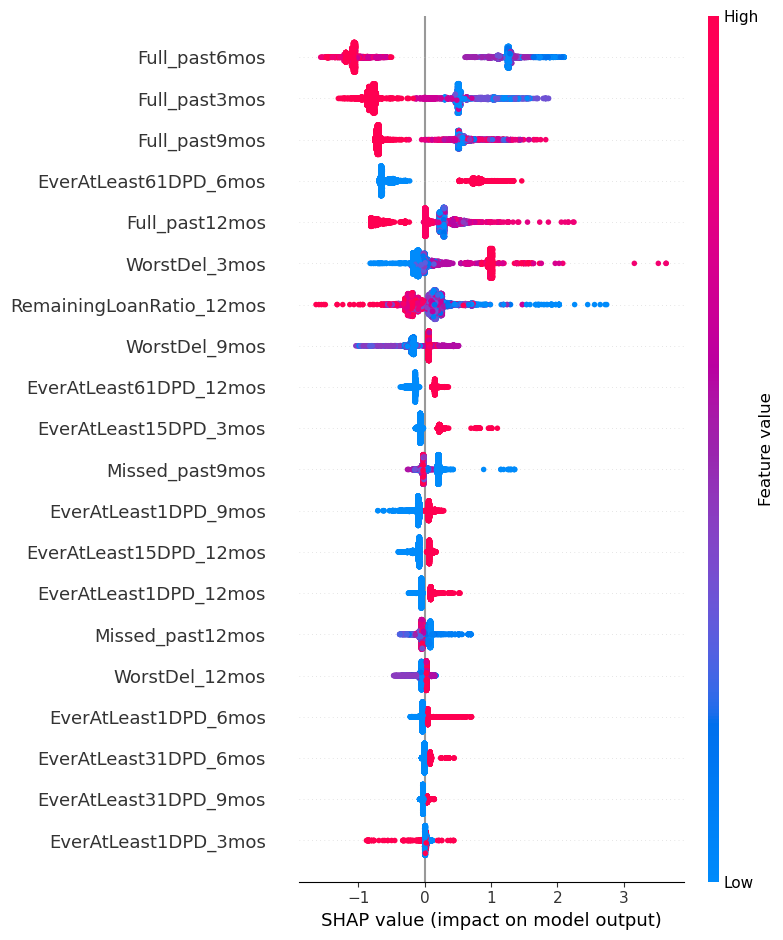

In [19]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train_split)
shap.summary_plot(shap_values, X_train_split)

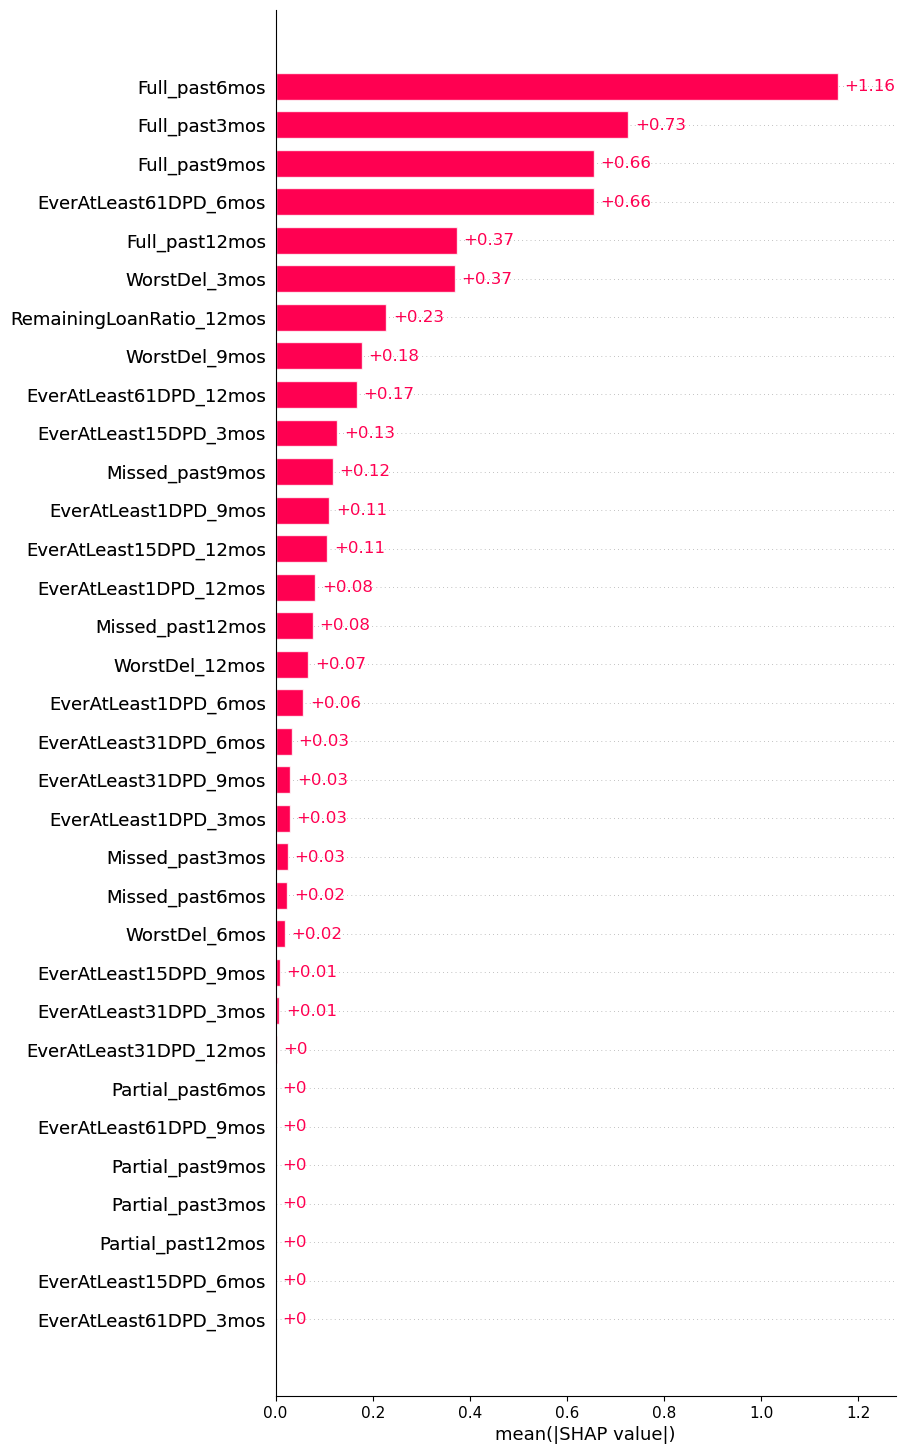

In [20]:
shap.plots.bar(shap_values, max_display=50)